In [51]:
import sys
sys.path.append('/home/cohen/lsst/codes/pipelines/photoz/SparsePz')
import numpy as np
from scipy import linalg as sla
from matplotlib import pylab as plt
%matplotlib inline

In [25]:
import pdf_storage as ps
import sys, os

try:
    from mpi4py import MPI

    PLL = 'MPI'
except ImportError:
    PLL = 'SERIAL'
from astropy.io import fits as pf


In [26]:
def get_limits(ntot, Nproc, rank):
    """
    Get limits for farming an array to multiple processors

    :param int ntot: Number of objects in array
    :param int Nproc: number of processor
    :param int rank: current processor id
    :return: L1,L2 the limits of the array for given processor
    :rtype: int, int
    """
    jpproc = zeros(Nproc) + int(ntot / Nproc)
    for i in range(Nproc):
        if (i < ntot % Nproc): jpproc[i] += 1
    jpproc = list(map(int, jpproc))
    st = rank
    st = sum(jpproc[:rank]) - 1
    s0 = int(st + 1)
    s1 = int(st + jpproc[rank]) + 1
    return s0, s1

In [28]:
if PLL == 'MPI':
    comm = MPI.COMM_WORLD
    size = comm.Get_size()
    rank = comm.Get_rank()
else:
    size = 1
    rank = 0

filein = '/home/cohen/lsst/codes/pipelines/photoz/SparsePz/CFHTLens_sample.P.npy'
#FORMAT FILE, EACH ROW IS THE PDF FOR EACH GALAXY, LAST ROW IS THE REDSHIFT POSITION

P = load(filein)
Ntot = len(P) - 1 #last row is redshift

if rank == 0:
    print("Total Galaxies = ", Ntot)
z = P[-1]
dz = z[1] - z[0]
if rank == 0:
    print('dz = ', dz)

mu = [min(z), max(z)]
Nmu = 250 #len(z)
max_sig = (max(z) - min(z)) / 12.
min_sig = dz / 6.
Nsig = int(ceil(2. * (max_sig - min_sig) / dz))
sig = [min_sig, max_sig]
Nv = 3
Nsig = 80
NA = Nmu * Nsig * Nv

if rank == 0:
    print('Nmu, Nsig, Nv = ', '[', Nmu, ',', Nsig, ',', Nv, ']')
    print('Total bases in dictionary', NA)

#Create dictionary
if rank == 0:
    print('Creating Dictionary...')
A = ps.create_voigt_dict(z, mu, Nmu, sig, Nsig, Nv)
bigD = {}

toler = 1.e-10
Nsparse = 20
Ncoef = 32001
AA = linspace(0, 1, Ncoef)
Da = AA[1] - AA[0]

if rank == 0:
    print('Nsparse (number of bases) = ', Nsparse)

bigD['z'] = z
bigD['mu'] = mu
bigD['sig'] = sig
bigD['dims'] = [Nmu, Nsig, Nv, Ncoef]
bigD['N_SPARSE'] = Nsparse
bigD['Ntot'] = Ntot

if rank == 0:
    for i in range(size):
        Xs_0, Xs_1 = get_limits(Ntot, size, i)
        print(Xs_0, ' ', Xs_1, ' -------------> to core ', i)

s0, s1 = get_limits(Ntot, size, rank)
P = P[s0:s1]

if rank == 0:
    print('Creating Sparse representation...')

for ik in range(Ntot):
    k = s0 + ik
    bigD[k] = {}
    try:
        pdf0 = P[ik]
    except:
        continue
    if np.sum(pdf0) > 0:
        pdf0 /= np.sum(pdf0)
    else:
        continue
        
    Dind, Dval = ps.sparse_basis(A, pdf0, Nsparse)
    if len(Dind) <= 1: continue
    bigD[k]['sparse'] = [Dind, Dval]
    if max(Dval) > 0:
        dval0=Dval[0]
        Dvalm = Dval / np.max(Dval)
        index = np.array(list(map(round, (Dvalm / Da))), dtype='int')
        index0=int(round(dval0/Da))
        index[0]=index0
    else:
        index = np.zeros(len(Dind), dtype='int')
    bigD[k]['sparse_ind'] = np.array(list(map(ps.combine_int, index, Dind)))

    #swap back columns
    A[:, [Dind]] = A[:, [np.arange(len(Dind))]]

print('Done with processor: ', rank)
if PLL == 'MPI': comm.Barrier()

if PLL == 'MPI':
    if rank == 0:
        for srank in np.arange(1, size):
            temp = comm.recv(source=srank, tag=srank * 2)
            bigD.update(temp)
            del temp
    else:
        comm.send(bigD, dest=0, tag=rank * 2)
    comm.Barrier()


if PLL == 'MPI':
    comm.Barrier()
    MPI.Finalize()


Total Galaxies =  100
dz =  0.010995000000000005
Nmu, Nsig, Nv =  [ 250 , 80 , 3 ]
Total bases in dictionary 60000
Creating Dictionary...
Nsparse (number of bases) =  20
0   100  -------------> to core  0
Creating Sparse representation...
Done with processor:  0


In [30]:
ALL = np.zeros((Ntot, Nsparse), dtype='int')
for i in range(Ntot):
    if i in bigD:
        idd = bigD[i]['sparse_ind']
        ALL[i, 0:len(idd)] = idd

In [43]:
meta = {}
#head['N_TOT'] = Ntot
meta['z'] = z
meta['Nmu'] = bigD['dims'][0]
meta['Nsig'] = bigD['dims'][1]
meta['Nv'] = bigD['dims'][2]
meta['Ncoef'] = bigD['dims'][3]
meta['N_SPARSE'] = bigD['N_SPARSE']
meta['mu'] = bigD['mu']
meta['sig'] = bigD['sig']

In [49]:
#Now build a voigt representation based on the sparse index and plot it
k=0
print(len(P[k]))
rep_pdf = ps.reconstruct_pdf_int(P[k], meta)

200


TypeError: ufunc 'right_shift' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

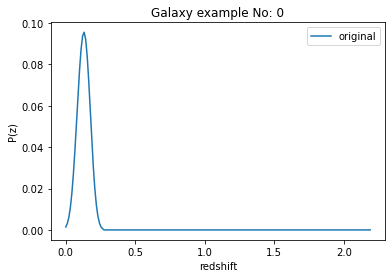

In [53]:
plt.plot(z, P[k] / sum(P[k]), label='original')
#plt.plot(z, rep_pdf, label='Sparse rep')
plt.xlabel('redshift')
plt.ylabel('P(z)')
plt.legend(loc=0)
title = 'Galaxy example No: %d' % k
plt.title(title);


In [ ]:
if False:
    print('Writing fits file (example_out.fits)')

    head = pf.Header()
    head['N_TOT'] = Ntot
    head['N_MU'] = bigD['dims'][0]
    head['N_SIGMA'] = bigD['dims'][1]
    head['N_VOIGT'] = bigD['dims'][2]
    head['N_COEF'] = bigD['dims'][3]
    head['N_SPARSE'] = bigD['N_SPARSE']
    head['MU1'] = bigD['mu'][0]
    head['MU2'] = bigD['mu'][1]
    head['SIGMA1'] = bigD['sig'][0]
    head['SIGMA2'] = bigD['sig'][1]

    col1 = pf.Column(name='redshift', format='E', array=bigD['z'])
    fmt = '%dJ' % bigD['N_SPARSE']
    col2 = pf.Column(name='Sparse_indices', format=fmt, array=ALL)
    table1 = pf.BinTableHDU.from_columns(pf.ColDefs([col1]))
    table2 = pf.BinTableHDU.from_columns(pf.ColDefs([col2]))
    prihdu = pf.PrimaryHDU(header=head)
    hdulist = pf.HDUList([prihdu, table1, table2])
    hdulist.writeto('example_out.fits', clobber=True)
